## Идея в том что бы обучить трансформер по текстовому описанию внешнего вида собаки определять ее породу
Выбраны 5 произвольных пород из тех, что придставлены в ImageNet

- Borzoi
- Cardigan
- Old_english_sheepdog
- Pug
- Scotch_terrier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import json
import random
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from datetime import datetime

## ФУНКЦИИ ДЛЯ DATA AUGMENTATION

In [ ]:
def augment_with_synonyms(text, augmentation_factor=3):
    """Аугментация текста с помощью синонимов"""
    # Словарь синонимов для ключевых слов
    synonym_dict = {
        # Размеры
        'small': ['little', 'tiny', 'compact', 'miniature', 'petite', 'diminutive'],
        'large': ['big', 'huge', 'sizeable', 'substantial', 'massive', 'imposing'],
        'medium': ['average', 'moderate', 'mid-sized', 'intermediate'],

        # Части тела
        'dog': ['canine', 'hound', 'pooch', 'mongrel', 'mut'],
        'coat': ['fur', 'hair', 'pelage', 'covering', 'jacket'],
        'tail': ['rear', 'appendage', 'brush', 'plume'],
        'ears': ['auricles', 'flaps', 'listeners'],
        'eyes': ['peepers', 'orbs', 'gaze', 'vision'],
        'nose': ['snout', 'muzzle', 'proboscis'],

        # Цвета
        'black': ['ebony', 'jet', 'onyx', 'sable', 'pitch'],
        'white': ['ivory', 'snowy', 'alabaster', 'pale', 'bleached'],
        'brown': ['chocolate', 'chestnut', 'mahogany', 'umber', 'russet'],
        'golden': ['gilded', 'amber', 'yellow', 'blond', 'tawny'],
        'gray': ['grey', 'silver', 'slate', 'ash', 'pewter'],

        # Текстура шерсти
        'wiry': ['bristly', 'stiff', 'coarse', 'rough', 'harsh'],
        'smooth': ['sleek', 'glossy', 'silky', 'soft', 'satiny'],
        'curly': ['wavy', 'frizzy', 'kinky', 'ringleted', 'crimped'],
        'shaggy': ['unkempt', 'matted', 'tousled', 'disheveled', 'scraggly'],
        'long': ['lengthy', 'extended', 'elongated', 'prolonged', 'drawn-out'],
        'short': ['brief', 'abbreviated', 'stubby', 'truncated', 'compressed'],

        # Черты характера
        'confident': ['self-assured', 'poised', 'self-possessed', 'assertive', 'bold'],
        'independent': ['self-reliant', 'autonomous', 'self-sufficient', 'self-directed'],
        'friendly': ['amicable', 'affable', 'companionable', 'sociable', 'genial'],
        'alert': ['vigilant', 'watchful', 'observant', 'attentive', 'keen'],
        'intelligent': ['clever', 'smart', 'bright', 'quick-witted', 'sharp'],
        'playful': ['frolicsome', 'frisky', 'sportive', 'merry', 'lively'],

        # Действия/функции
        'hunting': ['pursuing', 'chasing', 'tracking', 'stalking', 'seeking'],
        'herding': ['driving', 'guiding', 'rounding up', 'corralling', 'managing'],
        'guarding': ['protecting', 'watching over', 'defending', 'safeguarding'],
        'companion': ['friend', 'mate', 'partner', 'pal', 'buddy'],

        # Формы
        'rectangular': ['oblong', 'elongated box', 'linear', 'stretched'],
        'square': ['boxy', 'quadratic', 'four-sided', 'blocky'],
        'compact': ['dense', 'tight', 'condensed', 'concentrated', 'close-packed'],

        # Особые признаки
        'wrinkled': ['creased', 'lined', 'furrowed', 'corrugated', 'crumpled'],
        'floppy': ['droopy', 'hanging', 'pendulous', 'loose', 'flaccid'],
        'erect': ['upright', 'standing', 'perked', 'raised', 'vertical'],
        'curled': ['coiled', 'spiraled', 'twisted', 'wound', 'rolled'],
        'pushed-in': ['flattened', 'squashed', 'compressed', 'brachycephalic'],
    }

    words = text.split()
    augmented_texts = [text]  # Начинаем с оригинала

    for _ in range(augmentation_factor - 1):
        new_words = words.copy()

        # Случайное количество замен (30-50% слов)
        num_replacements = random.randint(max(1, len(words)//3), len(words)//2)
        indices_to_replace = random.sample(range(len(words)), num_replacements)

        for idx in indices_to_replace:
            word = new_words[idx].lower()
            # Убираем пунктуацию для сравнения
            clean_word = ''.join(c for c in word if c.isalpha())

            if clean_word in synonym_dict:
                new_word = random.choice(synonym_dict[clean_word])
                # Сохраняем оригинальный регистр
                if word[0].isupper():
                    new_word = new_word.capitalize()
                new_words[idx] = new_word

        augmented_texts.append(' '.join(new_words))

    return augmented_texts

In [ ]:
def augment_dataset(descriptions, labels, augmentation_factor=3):
    """Аугментация всего датасета"""
    augmented_descriptions = []
    augmented_labels = []

    for desc, label in zip(descriptions, labels):
        augmented_texts = augment_with_synonyms(desc, augmentation_factor)
        augmented_descriptions.extend(augmented_texts)
        augmented_labels.extend([label] * len(augmented_texts))

    print(f"Аугментация: {len(descriptions)} → {len(augmented_descriptions)} примеров")
    return augmented_descriptions, augmented_labels

In [ ]:
data_path = "dog_breeds_dataset.json"

## ЗАГРУЗКА И АУГМЕНТАЦИЯ ДАННЫХ

In [ ]:
class DogBreedsDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer, max_len=128):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        text = self.descriptions[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Загружаем сохраненные данные
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Загружаем токенайзер
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Аугментируем тренировочные данные
print("Аугментация тренировочных данных...")
augmented_train_desc, augmented_train_labels = augment_dataset(
    data['train']['descriptions'],
    data['train']['labels'],
    augmentation_factor=3  # Увеличиваем в 3 раза
)

# Создаем датасеты
train_dataset = DogBreedsDataset(
    augmented_train_desc,
    augmented_train_labels,
    tokenizer
)

val_dataset = DogBreedsDataset(
    data['val']['descriptions'],
    data['val']['labels'],
    tokenizer
)

test_dataset = DogBreedsDataset(
    data['test']['descriptions'],
    data['test']['labels'],
    tokenizer
)

# Создаем DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Маппинг меток
label_mapping = {int(k): v for k, v in data['label_mapping'].items()}

print(f"\nДанные загружены и аугментированы:")
print(f"  Train: {len(train_dataset)} samples (после аугментации)")
print(f"  Val: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")
print(f"  Label mapping: {label_mapping}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Аугментация тренировочных данных...
Аугментация: 315 → 945 примеров

Данные загружены и аугментированы:
  Train: 945 samples (после аугментации)
  Val: 68 samples
  Test: 68 samples
  Label mapping: {0: 'Borzoi', 1: 'Cardigan', 2: 'Old_english_sheepdog', 3: 'Pug', 4: 'Scotch_terrier'}


## Примеры сгенерированных описаний пород

In [ ]:
# Выводим первые 5 пар "ключ-значение"
for key, value in list(data.items())[:5]:
    print(f"{key}: {value}")


train: {'descriptions': ['This terrier’s compact build and rugged coat are hallmarks of its purpose', 'Bred for livestock work, its intelligence and agility shine through shaggy layers.', 'Low-maintenance coat and a tightly curled tail accentuate its stocky frame', 'A companion with a symmetrical build, expressive eyes, and a jaunty waddle', 'Hair hangs in heavy curtains, partially veiling its eyes and moderate forehead slope.', 'A devoted guardian, its watchful gaze and sturdy frame make it both a protector and a friend.', 'The abundant fur, often grizzle or blue-merle, frames a face brimming with character.', 'Its elongated silhouette and abbreviated limbs create a profile that is both unique and functional.', 'The short tail accentuates its distinctive, bear-like, shambling movement.', 'The very image of regal composure until prey appears—then pure, fluid motion', 'The arch of its back and the sweep of its tail are the signatures of its aristocratic heritage', 'Engaging and quirky, 

## АРХИТЕКТУРА МОДЕЛИ

In [ ]:
class CustomEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(vocab_size, embed_dim))
        nn.init.normal_(self.weight, mean=0.0, std=0.02)

    def forward(self, input_ids):
        return self.weight[input_ids]


class CustomSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=False)

        self.dropout = nn.Dropout(dropout)

    def _split_heads(self, x, batch_size):
        # x: (batch_size, seq_len, embed_dim)
        return x.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        # output: (batch_size, num_heads, seq_len, head_dim)

    def _combine_heads(self, x, batch_size):
        # x: (batch_size, num_heads, seq_len, head_dim)
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        # output: (batch_size, seq_len, embed_dim)

    def forward(self, query, key, value, key_padding_mask=None):
        batch_size = query.size(0)

        # 1. Linear projections
        Q = self.q_proj(query)
        K = self.k_proj(key)
        V = self.v_proj(value)

        # 2. Split into multiple heads
        Q = self._split_heads(Q, batch_size)
        K = self._split_heads(K, batch_size)
        V = self._split_heads(V, batch_size)

        # 3. Scaled Dot-Product Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # 4. Apply mask (if provided)
        if key_padding_mask is not None:
            mask = key_padding_mask.unsqueeze(1).unsqueeze(2) # (batch, 1, 1, seq_len)
            scores = scores.masked_fill(mask, -1e9) # Fill with a large negative number

        # 5. Apply softmax
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights) # Apply dropout to attention weights

        # 6. Multiply with V
        context = torch.matmul(attention_weights, V)

        # 7. Concatenate heads and final linear projection
        context = self._combine_heads(context, batch_size)
        output = self.out_proj(context)

        return output, attention_weights


class EnhancedTransformerLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.25):
        super().__init__()

        # Self-Attention с Pre-Norm
        self.norm1 = nn.LayerNorm(d_model)
        self.self_attn = CustomSelfAttention(d_model, num_heads, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)

        # Feed Forward Network с Pre-Norm
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, key_padding_mask=None):
        """key_padding_mask: (batch, seq_len) с True для padding токенов"""
        # Pre-Norm Self-Attention
        x_norm = self.norm1(x)
        attn_output, _ = self.self_attn(
            x_norm, x_norm, x_norm,
            key_padding_mask=key_padding_mask
        )
        x = x + self.dropout1(attn_output)

        # Pre-Norm Feed Forward
        x_norm = self.norm2(x)
        ff_output = self.ffn(x_norm)
        x = x + self.dropout2(ff_output)

        return x


class EnhancedTextTransformer(nn.Module):
    def __init__(self, vocab_size=30522, embed_dim=320, num_layers=4,
                 num_heads=8, ff_dim=1280, num_classes=5, max_seq_len=128,
                 dropout=0.25):
        super().__init__()

        self.token_embedding = CustomEmbedding(vocab_size, embed_dim)
        self.position_embedding = CustomEmbedding(max_seq_len, embed_dim)
        self.embed_dropout = nn.Dropout(dropout)

        self.encoder_layers = nn.ModuleList([
            EnhancedTransformerLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        self.layer_drop_prob = 0.1
        self.final_norm = nn.LayerNorm(embed_dim)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

        self._initialize_weights()

        self.config = {
            'vocab_size': vocab_size,
            'embed_dim': embed_dim,
            'num_layers': num_layers,
            'num_heads': num_heads,
            'ff_dim': ff_dim,
            'num_classes': num_classes,
            'max_seq_len': max_seq_len,
            'dropout': dropout,
            'layer_drop_prob': self.layer_drop_prob
        }

    def _initialize_weights(self):
        # CustomEmbedding handles its own weight initialization.

        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() > 1:
                # Apply Xavier uniform to all linear layers, excluding embedding weights
                # and LayerNorm weights (which are often initialized differently or don't need Xavier).
                if 'token_embedding' not in name and 'position_embedding' not in name and 'norm' not in name:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)

        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0.0)

    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_len = input_ids.size()

        # Embeddings
        token_embeds = self.token_embedding(input_ids)
        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, seq_len)
        pos_embeds = self.position_embedding(positions)

        x = token_embeds + pos_embeds
        x = self.embed_dropout(x)

        # Подготовка mask для CustomSelfAttention
        key_padding_mask = None
        if attention_mask is not None:
            key_padding_mask = (attention_mask == 0)  # True для padding

        # Encoder layers
        for i, encoder_layer in enumerate(self.encoder_layers):
            if self.training and random.random() < self.layer_drop_prob:
                continue

            x = encoder_layer(x, key_padding_mask)

        # Final normalization и классификация
        x = self.final_norm(x)
        cls_output = x[:, 0, :]
        logits = self.classifier(cls_output)

        return {'logits': logits, 'cls_embedding': cls_output}

In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            logits = outputs['logits']

            loss = criterion(logits, labels)
            total_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = total_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc

## Функция обучения

In [ ]:
def train_model_with_early_stopping(model, train_loader, val_loader, config):
    device = config['device']
    epochs = config['epochs']
    lr = config['learning_rate']

    # Weighted loss для балансировки классов
    from collections import Counter
    class_counts = Counter(augmented_train_labels)
    total_samples = sum(class_counts.values())
    class_weights = torch.zeros(max(augmented_train_labels) + 1)

    for label, count in class_counts.items():
        class_weights[label] = total_samples / (len(class_counts) * count)

    class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=config['weight_decay'],
        betas=(0.9, 0.999),
        eps=1e-8
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'learning_rates': []
    }

    best_val_acc = 0
    patience_counter = 0
    patience = config['patience']
    best_model_state = None

    print("\n" + "="*60)
    print("НАЧАЛО ОБУЧЕНИЯ С РАННЕЙ ОСТАНОВКОЙ")
    print("="*60)
    print(f"Параметров модели: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(epochs):
        print(f"\nЭпоха {epoch+1}/{epochs}")
        print("-" * 50)

        # Обучение
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            logits = outputs['logits']

            loss = criterion(logits, labels)

            # L1 регуляризация
            if config.get('l1_lambda', 0) > 0:
                l1_reg = 0
                for param in model.parameters():
                    l1_reg += torch.norm(param, 1)
                loss += config['l1_lambda'] * l1_reg

            loss.backward()

            # Gradient clipping
            if config.get('grad_clip', 0) > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Обновление learning rate
        scheduler.step()

        train_loss = train_loss / len(train_loader)
        train_acc = 100.0 * train_correct / train_total

        # Валидация
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"LR: {history['learning_rates'][-1]:.6f}")

        # Проверка ранней остановки
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'config': model.config,
                'val_acc': val_acc,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'train_loss': train_loss,
            }
            torch.save(best_model_state, '/content/drive/MyDrive/Homework_ML/10_transformer_txt/best_enhanced_model.pth')
            print(f"✓ Модель сохранена (val acc: {val_acc:.2f}%)")
        else:
            patience_counter += 1
            print(f"Patience counter: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print(f"\nРанняя остановка на эпохе {epoch+1}")
                print(f"Лучшая Val Accuracy: {best_val_acc:.2f}%")

                if best_model_state:
                    model.load_state_dict(best_model_state['model_state_dict'])
                break

    print(f"\nОбучение завершено!")
    print(f"Лучшая Val Accuracy: {best_val_acc:.2f}%")

    return history, best_val_acc

## Конфигурация модели и обучения

In [ ]:
# Создаем улучшенную модель
model = EnhancedTextTransformer(
    vocab_size=tokenizer.vocab_size,
    embed_dim=320,      # Увеличили размерность
    num_layers=4,       # Увеличили количество слоев
    num_heads=8,        # Увеличили количество голов внимания
    ff_dim=1280,        # Увеличили размер FFN
    num_classes=5,
    max_seq_len=128,
    dropout=0.25        # Увеличили dropout
)

# Улучшенная конфигурация обучения
ENHANCED_CONFIG = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'epochs': 30,                      # Больше эпох для ранней остановки
    'learning_rate': 3e-4,              # Увеличили learning rate
    'weight_decay': 0.01,               # L2 регуляризация
    'l1_lambda': 0.0001,                # L1 регуляризация
    'batch_size': 16,
    'grad_clip': 1.0,                   # Gradient clipping
    'patience': 3                      # Ранняя остановка после 7 эпох без улучшений
}

print(f"\nКонфигурация модели:")
for key, value in model.config.items():
    print(f"  {key}: {value}")

print(f"\nКонфигурация обучения:")
for key, value in ENHANCED_CONFIG.items():
    print(f"  {key}: {value}")

# Проверка модели перед обучением
print("\nПроверка выходов модели до обучения:")
model.eval()
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'][:2]
        attention_mask = batch['attention_mask'][:2]

        outputs = model(input_ids, attention_mask)
        logits = outputs['logits']
        probabilities = F.softmax(logits, dim=1)

        print(f"Logits shape: {logits.shape}")
        print(f"Probabilities: {probabilities}")
        break


Конфигурация модели:
  vocab_size: 30522
  embed_dim: 320
  num_layers: 4
  num_heads: 8
  ff_dim: 1280
  num_classes: 5
  max_seq_len: 128
  dropout: 0.25
  layer_drop_prob: 0.1

Конфигурация обучения:
  device: cpu
  epochs: 30
  learning_rate: 0.0003
  weight_decay: 0.01
  l1_lambda: 0.0001
  batch_size: 16
  grad_clip: 1.0
  patience: 3

Проверка выходов модели до обучения:
Logits shape: torch.Size([2, 5])
Probabilities: tensor([[0.4414, 0.2237, 0.0692, 0.0984, 0.1674],
        [0.2873, 0.1988, 0.1193, 0.1912, 0.2035]])


# Запуск обучения

In [ ]:
model.to(ENHANCED_CONFIG['device'])
history, best_val_acc = train_model_with_early_stopping(
    model, train_loader, val_loader, ENHANCED_CONFIG
)

## Сохранение истории обучения

In [ ]:
def save_training_history(history, filename='/content/drive/MyDrive/Homework_ML/10_transformer_txt/dog_breeds_training_history.json'):
    """
    Сохраняет историю обучения в JSON файл

    Args:
        history (dict): Словарь с историей обучения
        filename (str): Имя файла для сохранения
    """
    # Конвертируем numpy массивы в списки для сохранения в JSON
    history_for_save = {}

    for key, value in history.items():
        if isinstance(value, list) and len(value) > 0:
            # Если в списке есть numpy типы, конвертируем
            if isinstance(value[0], np.generic):
                history_for_save[key] = [float(v) for v in value]
            else:
                history_for_save[key] = value
        else:
            history_for_save[key] = value

    # Добавляем метаданные
    history_for_save['metadata'] = {
        'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_epochs': len(history['train_loss']),
        'best_val_acc': max(history['val_acc']) if 'val_acc' in history else None,
        'best_train_acc': max(history['train_acc']) if 'train_acc' in history else None,
        'final_lr': history['learning_rates'][-1] if 'learning_rates' in history else None
    }

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(history_for_save, f, indent=2, ensure_ascii=False)

    print(f"История обучения сохранена в {filename}")
    print(f"Метаданные: {history_for_save['metadata']}")

    return history_for_save

In [ ]:
# Сохраняем историю
%%capture
save_training_history(history, '/content/drive/MyDrive/Homework_ML/10_transformer_txt/dog_breeds_training_history.json')

## Загрузка истории обучения

In [ ]:
def load_training_history(filename='/content/drive/MyDrive/Homework_ML/10_transformer_txt/dog_breeds_training_history.json'):
    """
    Загружает историю обучения из JSON файла

    Args:
        filename (str): Имя файла для загрузки

    Returns:
        dict: Загруженная история обучения
    """
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            loaded_history = json.load(f)

        print(f"История обучения загружена из {filename}")
        print(f"Метаданные:")
        for key, value in loaded_history.get('metadata', {}).items():
            print(f"  {key}: {value}")

        # Убираем метаданные из основной истории
        if 'metadata' in loaded_history:
            metadata = loaded_history.pop('metadata')
            return loaded_history, metadata
        else:
            return loaded_history, {}

    except FileNotFoundError:
        print(f"Файл {filename} не найден")
        return None, {}
    except json.JSONDecodeError as e:
        print(f"Ошибка при чтении JSON файла: {e}")
        return None, {}

In [ ]:
# Пример загрузки
history, metadata = load_training_history('/content/drive/MyDrive/Homework_ML/10_transformer_txt/dog_breeds_training_history.json')

История обучения загружена из /content/drive/MyDrive/Homework_ML/10_transformer_txt/dog_breeds_training_history.json
Метаданные:
  saved_at: 2025-12-20 20:43:39
  total_epochs: 9
  best_val_acc: 94.11764705882354
  best_train_acc: 99.47089947089947
  final_lr: 8.317050813874547e-06


## Визуализация процесса обучения

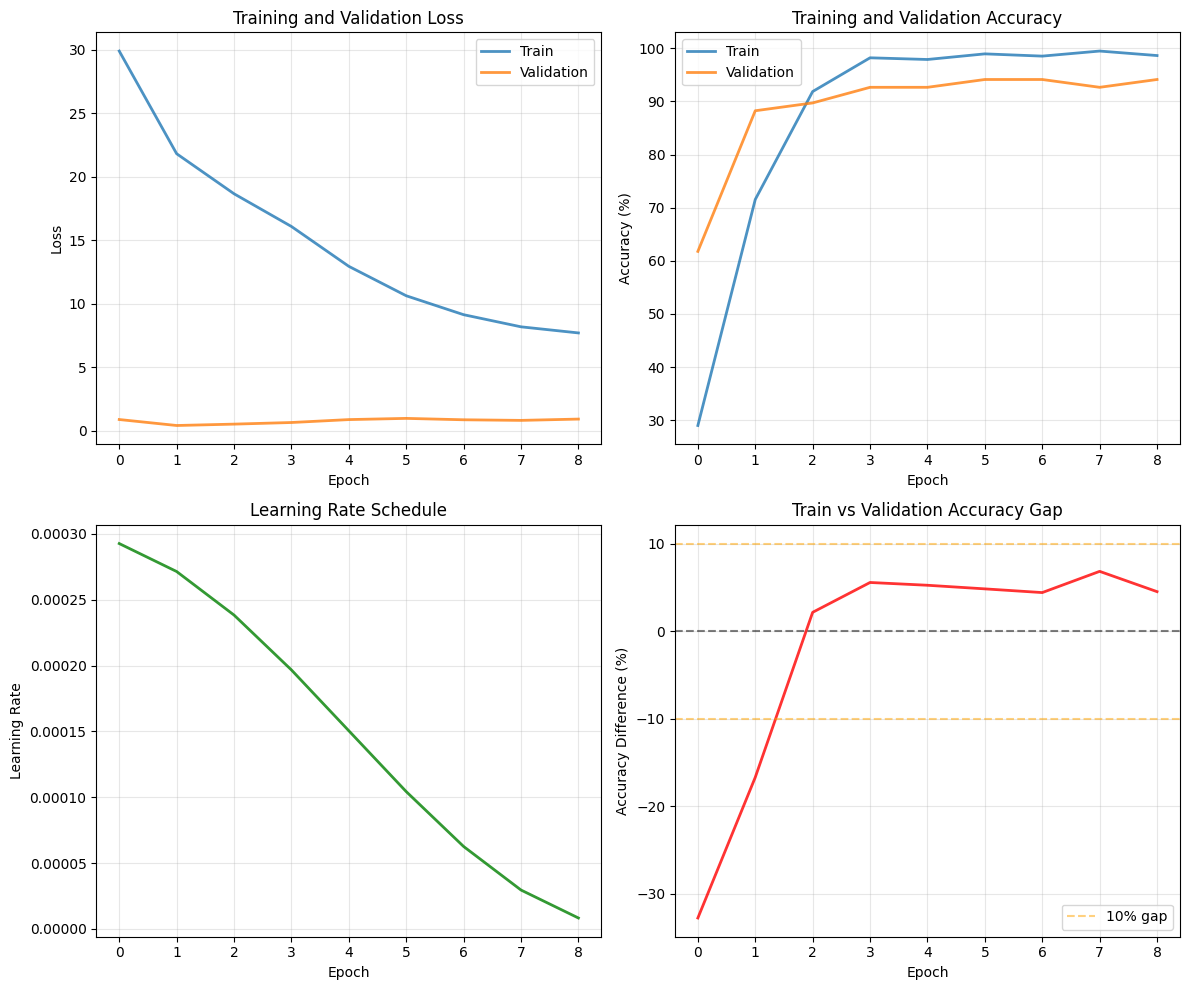

In [ ]:
def plot_enhanced_training_history(history):
    """Визуализация истории обучения"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2, alpha=0.8)
    axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2, alpha=0.8)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2, alpha=0.8)
    axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2, alpha=0.8)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 0].plot(history['learning_rates'], linewidth=2, color='green', alpha=0.8)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)

    # Train vs Val Accuracy разница
    diff = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1, 1].plot(diff, linewidth=2, color='red', alpha=0.8)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].axhline(y=10, color='orange', linestyle='--', alpha=0.5, label='10% gap')
    axes[1, 1].axhline(y=-10, color='orange', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy Difference (%)')
    axes[1, 1].set_title('Train vs Validation Accuracy Gap')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    plt.show()

# Визуализируем
plot_enhanced_training_history(history)

## Тестирование модели


In [ ]:

def test_enhanced_model(model, test_loader, label_mapping, device):
    """Тестирование улучшенной модели"""
    model.eval()

    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            logits = outputs['logits']
            probabilities = F.softmax(logits, dim=1)
            _, predicted = torch.max(logits, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Конвертируем label_mapping
    idx_to_label = {int(k): v for k, v in label_mapping.items()}

    # Вычисляем accuracy
    accuracy = 100.0 * sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)

    print("\n" + "="*60)
    print("ТЕСТИРОВАНИЕ УЛУЧШЕННОЙ МОДЕЛИ")
    print("="*60)

    print(f"\nTest Accuracy: {accuracy:.2f}%")

    print("\nClassification Report:")
    print(classification_report(
        all_labels, all_predictions,
        target_names=[idx_to_label[i] for i in range(len(idx_to_label))],
        digits=4
    ))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[idx_to_label[i] for i in range(len(idx_to_label))],
                yticklabels=[idx_to_label[i] for i in range(len(idx_to_label))])
    plt.title(f'Confusion Matrix (Accuracy: {accuracy:.1f}%)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # По-породная точность
    print("\nПо-породная точность:")
    for i in range(len(idx_to_label)):
        breed_name = idx_to_label[i]
        breed_indices = np.where(np.array(all_labels) == i)[0]
        if len(breed_indices) > 0:
            breed_correct = sum(np.array(all_predictions)[breed_indices] == i)
            breed_acc = 100.0 * breed_correct / len(breed_indices)
            print(f"  {breed_name}: {breed_acc:.1f}% ({breed_correct}/{len(breed_indices)})")

    return accuracy, all_predictions, all_labels, all_probabilities




## Загрузка лучшей модели и ее тестирование


Лучшая улучшенная модель загружена (эпоха 6)
Val Accuracy при сохранении: 94.12%

ТЕСТИРОВАНИЕ УЛУЧШЕННОЙ МОДЕЛИ

Test Accuracy: 92.65%

Classification Report:
                      precision    recall  f1-score   support

              Borzoi     1.0000    0.8667    0.9286        15
            Cardigan     0.9286    0.9286    0.9286        14
Old_english_sheepdog     0.9231    0.9231    0.9231        13
                 Pug     0.9231    1.0000    0.9600        12
      Scotch_terrier     0.8667    0.9286    0.8966        14

            accuracy                         0.9265        68
           macro avg     0.9283    0.9294    0.9274        68
        weighted avg     0.9296    0.9265    0.9265        68



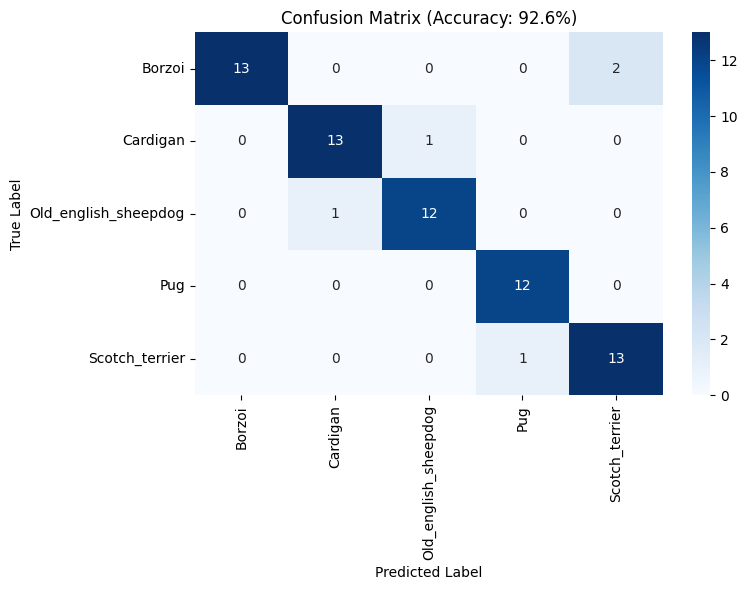


По-породная точность:
  Borzoi: 86.7% (13/15)
  Cardigan: 92.9% (13/14)
  Old_english_sheepdog: 92.3% (12/13)
  Pug: 100.0% (12/12)
  Scotch_terrier: 92.9% (13/14)


In [ ]:
# Загружаем лучшую модель
checkpoint = torch.load('/content/drive/MyDrive/Homework_ML/10_transformer_txt/best_enhanced_model.pth', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nЛучшая улучшенная модель загружена (эпоха {checkpoint['epoch'] + 1})")
print(f"Val Accuracy при сохранении: {checkpoint['val_acc']:.2f}%")

# Тестируем
test_accuracy, predictions, true_labels, probabilities = test_enhanced_model(
    model, test_loader, label_mapping, ENHANCED_CONFIG['device']
)

## Анализ ошибок предсказания

In [ ]:
def analyze_predictions(predictions, true_labels, test_descriptions, idx_to_label):
    """Анализ предсказаний модели"""
    from collections import defaultdict

    errors_by_breed = defaultdict(list)
    correct_by_breed = defaultdict(list)

    for i, (pred, true, desc) in enumerate(zip(predictions, true_labels, test_descriptions)):
        breed_name = idx_to_label[true]

        if pred == true:
            correct_by_breed[breed_name].append(desc)
        else:
            pred_name = idx_to_label[pred]
            errors_by_breed[breed_name].append({
                'predicted': pred_name,
                'description': desc
            })

    print("\n" + "="*60)
    print("АНАЛИЗ ТОЧНОСТИ ПО ПОРОДАМ")
    print("="*60)

    for breed in idx_to_label.values():
        total = len([l for l in true_labels if idx_to_label[l] == breed])
        correct = len(correct_by_breed.get(breed, []))
        accuracy = 100.0 * correct / total if total > 0 else 0

        print(f"\n{breed}:")
        print(f"  Точность: {accuracy:.1f}% ({correct}/{total})")

        if breed in errors_by_breed:
            print(f"  Основные ошибки:")
            error_counts = Counter([e['predicted'] for e in errors_by_breed[breed]])
            for pred_breed, count in error_counts.most_common(3):
                print(f"    → {pred_breed}: {count} раз")

            # Пример самой частой ошибки
            if errors_by_breed[breed]:
                most_common_error = error_counts.most_common(1)[0][0]
                example_error = next(e for e in errors_by_breed[breed] if e['predicted'] == most_common_error)
                print(f"    Пример: \"{example_error['description'][:80]}...\"")
                print(f"    Предсказано как: {example_error['predicted']}")

# Анализируем предсказания
analyze_predictions(
    predictions,
    true_labels,
    data['test']['descriptions'],
    {int(k): v for k, v in label_mapping.items()}
)



АНАЛИЗ ТОЧНОСТИ ПО ПОРОДАМ

Borzoi:
  Точность: 86.7% (13/15)
  Основные ошибки:
    → Scotch_terrier: 2 раз
    Пример: "Designed for open spaces, where its ground-covering stride truly comes alive..."
    Предсказано как: Scotch_terrier

Cardigan:
  Точность: 92.9% (13/14)
  Основные ошибки:
    → Old_english_sheepdog: 1 раз
    Пример: "The dense double coat and substantial bone structure equip it for demanding farm..."
    Предсказано как: Old_english_sheepdog

Old_english_sheepdog:
  Точность: 92.3% (12/13)
  Основные ошибки:
    → Cardigan: 1 раз
    Пример: "Enveloped in a cascade of tousled, gray-and-white fur, this dog exudes rustic ch..."
    Предсказано как: Cardigan

Pug:
  Точность: 100.0% (12/12)

Scotch_terrier:
  Точность: 92.9% (13/14)
  Основные ошибки:
    → Pug: 1 раз
    Пример: "Bred for underground pursuit, its physique combines condensed power and agility..."
    Предсказано как: Pug


# ИНФЕРЕНС ДЛЯ РУЧНОГО ТЕСТИРОВАНИЯ МОДЕЛИ

In [ ]:
def format_breed_name(breed_name):
    """Форматирует название породы для отображения"""
    return breed_name.replace('_', ' ').title()

def predict_breed(model, tokenizer, text, label_mapping, device='cpu'):
    """Предсказывает породу собаки по текстовому описанию"""
    model.eval()
    model.to(device)

    # Токенизация
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        logits = outputs['logits']
        probabilities = F.softmax(logits, dim=1)

    probs = probabilities.cpu().numpy()[0]
    idx_to_label = {int(k): v for k, v in label_mapping.items()}

    # Словарь вероятностей (с отформатированными названиями)
    probabilities_dict = {}
    for idx, prob in enumerate(probs):
        breed_name = idx_to_label[idx]
        display_name = format_breed_name(breed_name)
        probabilities_dict[display_name] = float(prob * 100)

    # Находим лучшую породу
    predicted_idx = np.argmax(probs)
    predicted_breed = idx_to_label[predicted_idx]
    predicted_display = format_breed_name(predicted_breed)

    return predicted_display, probabilities_dict

def print_prediction(text, predicted_breed, probabilities_dict, true_breed=None):
    """Красивый вывод результатов"""
    print(f"\n{'='*60}")
    print(f"ТЕКСТ: \"{text}\"")
    print(f"{'='*60}")
    print(f"\n ПРЕДСКАЗАНА ПОРОДА: {predicted_breed}")
    print(f"\n ВЕРОЯТНОСТИ ПО ПОРОДАМ:")

    # Сортируем по убыванию вероятности
    sorted_probs = sorted(probabilities_dict.items(), key=lambda x: x[1], reverse=True)

    for breed, prob in sorted_probs:
        bar_length = 20
        filled_length = int(bar_length * prob / 100)
        bar = '█' * filled_length + '░' * (bar_length - filled_length)
        print(f"  {breed:25s} {bar} {prob:5.1f}%")

    confidence = probabilities_dict.get(predicted_breed, 0)
    print(f"\n Уверенность модели: {confidence:.1f}%")

    # Проверяем правильность предсказания, если передана истинная порода
    if true_breed:
        if predicted_breed == true_breed:
            print(f"\n ✓ Модель угадала правильно!")
        else:
            print(f"\n ✗ Модель ошиблась. Правильно: {true_breed}")

# ============================================
# ТЕСТОВЫЕ ПРИМЕРЫ (которые модель не видела)
# ============================================

test_examples = [
    # Scotch Terrier (новые описания)
    ("Compact vermin-hunter with rectangular silhouette and piercing gaze", "Scotch Terrier"),
    ("A determined little terrier featuring coarse wire-like fur and self-assured demeanor", "Scotch Terrier"),

    # Pug (новые описания)
    ("Squat canine companion characterized by deeply furrowed brow and snub nose", "Pug"),
    ("A merry lapdog displaying glossy coat and tightly wound corkscrew tail", "Pug"),

    # Borzoi (новые описания)
    ("Willowy aristocrat of canine world with sweeping curves and silent grace", "Borzoi"),
    ("Tall coursing hound distinguished by aquiline profile and cascading silken hair", "Borzoi"),

    # Cardigan (новые описания)
    ("Low-slung herder possessing elongated frame and fox-like brush tail", "Cardigan"),
    ("Sturdy working breed with abbreviated legs and prominent upright ears", "Cardigan"),

    # Old English Sheepdog (новые описания)
    ("Shaggy-coated drover whose vision is partially obscured by abundant facial hair", "Old English Sheepdog"),
    ("Ambulating teddy bear with rolling bear-like gait and resonant distinctive bark", "Old English Sheepdog")
]

# ============================================
# ГЛАВНОЕ МЕНЮ ИНФЕРЕНСА
# ============================================

print("="*60)
print("ИНФЕРЕНС МОДЕЛИ ДЛЯ КЛАССИФИКАЦИИ ПОРОД СОБАК")
print("="*60)

# Загружаем лучшую модель
try:
    checkpoint = torch.load('best_enhanced_model.pth', map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Модель загружена (Val Accuracy: {checkpoint['val_acc']:.2f}%)")
except Exception as e:
    print(f"⚠ Не удалось загрузить модель: {e}")
    print("⚠ Используется текущая модель")

print("\nДоступные породы:")
print("1. Scotch Terrier")
print("2. Pug")
print("3. Borzoi")
print("4. Cardigan")
print("5. Old English Sheepdog")

while True:
    print("\n" + "="*60)
    print("ВЫБЕРИТЕ РЕЖИМ:")
    print("1. Выбрать готовый пример")
    print("2. Ввести свое описание на английском")
    print("3. Выход")
    print("="*60)

    choice = input("Ваш выбор (1-3): ").strip()

    if choice == '3':
        print("Завершение работы...")
        break

    elif choice == '1':
        print("\nДОСТУПНЫЕ ПРИМЕРЫ:")
        for i, (example_text, true_breed) in enumerate(test_examples, 1):
            # Обрезаем текст для компактного отображения
            preview = example_text[:60] + "..." if len(example_text) > 60 else example_text
            print(f"{i:2d}. {preview} ({true_breed})")

        while True:
            try:
                example_choice = input("\nВыберите номер примера (1-10) или 'назад': ").strip()

                if example_choice.lower() in ['назад', 'back', 'b']:
                    break

                example_idx = int(example_choice) - 1
                if 0 <= example_idx < len(test_examples):
                    example_text, true_breed = test_examples[example_idx]

                    print(f"\nВыбран пример {example_choice}:")
                    print(f"Описание: {example_text}")
                    print(f"Истинная порода: {true_breed}")

                    predicted_breed, probabilities = predict_breed(
                        model, tokenizer, example_text, label_mapping, ENHANCED_CONFIG.get('device', 'cpu')
                    )

                    # Передаем true_breed для проверки правильности
                    print_prediction(example_text, predicted_breed, probabilities, true_breed)

                    input("\nНажмите Enter для продолжения...")
                    break
                else:
                    print("⚠ Пожалуйста, выберите число от 1 до 10")
            except ValueError:
                print("⚠ Пожалуйста, введите число")
            except Exception as e:
                print(f"⚠ Ошибка при обработке примера: {e}")

    elif choice == '2':
        print("\n" + "="*60)
        print("ВВЕДИТЕ ОПИСАНИЕ НА АНГЛИЙСКОМ")
        print("Примеры хороших описаний:")
        print("- 'A small dog with a wrinkled muzzle and a curled tail' (Pug)")
        print("- 'A very tall slender dog with aristocratic bearing' (Borzoi)")
        print("- 'A long-bodied dog with very short legs' (Cardigan)")
        print("- 'A large shaggy dog with hair covering its eyes' (Old English Sheepdog)")
        print("- 'A compact terrier with wiry coat and erect ears' (Scotch Terrier)")
        print("="*60)

        while True:
            user_input = input("\nВаше описание (или 'назад' для возврата): ").strip()

            if user_input.lower() in ['назад', 'back', 'b']:
                break

            if not user_input:
                print("⚠ Пожалуйста, введите описание")
                continue

            if len(user_input.split()) < 3:
                print("⚠ Описание слишком короткое. Минимум 3 слова.")
                continue

            try:
                predicted_breed, probabilities = predict_breed(
                    model, tokenizer, user_input, label_mapping, ENHANCED_CONFIG.get('device', 'cpu')
                )
                # Для пользовательского ввода не передаем true_breed
                print_prediction(user_input, predicted_breed, probabilities)

                # Спрашиваем, хочет ли пользователь знать правильный ответ
                know_answer = input("\nСравним ответы? (да/нет): ").strip().lower()
                if know_answer in ['да', 'yes', 'y', 'д']:
                    print("\nКакую породу вы описывали?")
                    print("1. Scotch Terrier")
                    print("2. Pug")
                    print("3. Borzoi")
                    print("4. Cardigan")
                    print("5. Old English Sheepdog")

                    while True:
                        breed_choice = input("Выберите номер породы (1-5): ").strip()
                        if breed_choice in ['1', '2', '3', '4', '5']:
                            breed_names = ['Scotch Terrier', 'Pug', 'Borzoi', 'Cardigan', 'Old English Sheepdog']
                            true_breed = breed_names[int(breed_choice) - 1]

                            # Используем функцию format_breed_name для сравнения
                            formatted_predicted = format_breed_name(predicted_breed)

                            if formatted_predicted == true_breed:
                                print(f"\n ✓ Модель правильно определила вашу породу!")
                            else:
                                print(f"\n ✗ Модель ошиблась. Вы описывали: {true_breed}")
                                print(f"   Предсказание модели: {formatted_predicted}")
                            break
                        else:
                            print("⚠ Пожалуйста, выберите число от 1 до 5")

                input("\nНажмите Enter для продолжения...")
                break

            except Exception as e:
                print(f"⚠ Ошибка: {e}")
                print("Попробуйте снова или введите 'назад'")

    else:
        print("⚠ Пожалуйста, выберите 1, 2 или 3")

print("\n" + "="*60)
print("ИНФЕРЕНС ЗАВЕРШЕН!")
print("="*60)

ИНФЕРЕНС МОДЕЛИ ДЛЯ КЛАССИФИКАЦИИ ПОРОД СОБАК
⚠ Не удалось загрузить модель: [Errno 2] No such file or directory: 'best_enhanced_model.pth'
⚠ Используется текущая модель

Доступные породы:
1. Scotch Terrier
2. Pug
3. Borzoi
4. Cardigan
5. Old English Sheepdog

ВЫБЕРИТЕ РЕЖИМ:
1. Выбрать готовый пример
2. Ввести свое описание на английском
3. Выход
Ваш выбор (1-3): 3
Завершение работы...

ИНФЕРЕНС ЗАВЕРШЕН!
